In [74]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,PowerTransformer,StandardScaler

import statsmodels.api as sm
from statsmodels.graphics import tsaplots

pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [257]:
# Modify iceoff day factor into category
def modify_iceoff_day(x,iceoff_name):
    if x[iceoff_name]>=30:
        return 3
    elif (x[iceoff_name]<30)&(x[iceoff_name]>=20):
        return 2
    elif (x[iceoff_name]<20)&(x[iceoff_name]>=10):
        return 1
    elif (x[iceoff_name]<10)&(x[iceoff_name]>=-10):
        return 0
    elif (x[iceoff_name]<-10)&(x[iceoff_name]>=-20):
        return -1
    elif (x[iceoff_name]<-20)&(x[iceoff_name]>=-30):
        return -2
    else:
        return -3
## Modifiy ice duration
def modify_ice_d(x,ice_d_name):
    if x[ice_d_name]>60:
        return 'long'
    elif (x[ice_d_name]<=60) & (x[ice_d_name]>30):
        return 'middle'
    elif (x[ice_d_name]<=30) & (x[ice_d_name]>0):
        return 'short'
    else:
        return 'no_ice_d'
# Modify zooplankton 
def modify_Daphnia(x,Daphnia):
    if x[Daphnia]>400:
        return 'high'
    elif (x[Daphnia]<=400) & (x[Daphnia]>200):
        return 'middle'
    elif (x[Daphnia]<=200) & (x[Daphnia]>50):
        return 'low'
    else:
        return 'little'

# Load testing dataset(Daily data)
def read_daily_test_df(features,Ice_c,iceoff_name,ice_d_name,zoo_name,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    #Ice categorization
    if Ice_c=='Y':
        Lake_HydMet[iceoff_name]=Lake_HydMet.apply(lambda x:modify_iceoff_day(x,iceoff_name), axis=1)
        Lake_HydMet[iceoff_name]=pd.Categorical(Lake_HydMet[iceoff_name])
        Lake_HydMet[ice_d_name]=Lake_HydMet.apply(lambda x:modify_ice_d(x,ice_d_name), axis=1)
        Lake_HydMet[ice_d_name]=pd.Categorical(Lake_HydMet[ice_d_name])
        Lake_HydMet=pd.concat([Lake_HydMet,pd.get_dummies(Lake_HydMet[[iceoff_name,ice_d_name]])],
                      axis=1).drop([iceoff_name,ice_d_name],axis=1)              
    if zoo_c=='Y':
        Lake_HydMet[zoo_name]=Lake_HydMet.apply(lambda x:modify_Daphnia(x,zoo_name), axis=1)
        Lake_HydMet[zoo_name]=pd.Categorical(Lake_HydMet[zoo_name])
        Lake_HydMet=pd.concat([Lake_HydMet,pd.get_dummies(Lake_HydMet[[zoo_name]])],
              axis=1).drop([zoo_name],axis=1)              

    Lake_HydMet = Lake_HydMet[features]
    #Lake_HydMet = Lake_HydMet[(Lake_HydMet['Date']>=test_time[0])&(Lake_HydMet['Date']<=test_time[1])].dropna()
    return Lake_HydMet

# Train and cross-validate the model
def training_cv(df,features,nutrient,year,loss_func):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    features.append(nutrient)
    df = df[df['YY'].isin(year)][features].dropna()
    X_train = df.iloc[:,:-1]
    y_train = df.iloc[:,-1].values
    print('Number of samples: ' + str(len(y_train)))

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    GBR.set_params(**GBR_rs.best_params_,random_state=101,loss=loss_func).fit(X_train,y_train)
    mae= -cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_absolute_error')
    rmse = np.sqrt(-cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_mean_squared_error'))
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("MAE %.2f (+/- %.2f)" % (mae.mean(), mae.std()))
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))
    features.pop() 
    
# Make prediction with trained model
def predict(Erken_Nut,df,features,nutrient,test_time,ylim,Lake_Nut_metrics):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Erken_Nut[nutrient]=GBR.predict(Erken_Nut[features])
    #Erken_Nut[nutrient]=Erken_Nut[nutrient].rolling(7,min_periods = 1,center=True).mean()
    nutrient_compare = Erken_Nut[['Date',nutrient]].merge(df[['Date',nutrient]].dropna(),
                                                          how = 'inner',on = 'Date')
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                      end = test_time[1]),
                    columns = ['Date'])
    #Erken_Nut_gap = Date.merge(Erken_Nut,how = 'left',on = 'Date')
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']>=test_time[0])&(nutrient_compare['Date']<=test_time[1])]
    Lake_Nut_metrics[nutrient]['MAE']=mean_absolute_error(nutrient_compare['True'],
                                                          nutrient_compare['Prediction'])
    Lake_Nut_metrics[nutrient]['RMSE']=mean_squared_error(nutrient_compare['True'],
                                                          nutrient_compare['Prediction'],
                                                          squared = False)    
    Lake_Nut_metrics[nutrient]['R2']=r2_score(nutrient_compare['True'],
                                              nutrient_compare['Prediction'])
    return Erken_Nut[['Date',nutrient]],Lake_Nut_metrics

# LSTM model functions
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose,loss_function):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(np.concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    pred.loc[pred['Prediction']<0,'Prediction']=0
    rmse=mean_squared_error(pred['True value'], pred['Prediction'],squared=False)
    mae=mean_absolute_error(pred['True value'], pred['Prediction'])
    r2=r2_score(pred['True value'], pred['Prediction'])
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    pred_ts.loc[pred_ts['Prediction']<0,'Prediction']=0
    pred_ts.loc[pred_ts['Prediction_7d']<0,'Prediction_7d']=0
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}, MAE:{}'.format(round(rmse,2),round(mae,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    ax1[0].legend(frameon=False)
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1,pred_ts

# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[(df['Date']<test_time[0])|(df['Date']>test_time[1])]['Date'].count() # number of dates used for trainning
    if df[(df['Date']<test_time[0])].empty:
        train = values[-n_date-1:-1, :] # Testing years are in front of training years: train = values[-n_date-1:-1, :]
        test = values[:-n_date, :] # Testing years are in front of training years: test = values[:-n_date, :]
    if df[(df['Date']>test_time[1])].empty:
        train = values[:n_date, :] # Testing years are after training years: train = values[:n_date, :]
        test = values[n_date:, :] # Testing years are after training years: test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    train_y=Scaler_y.fit_transform(train_y.reshape(-1, 1))
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    #y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    MAE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],
                         hyperparameters['verbose'],hyperparameters['loss_function'])
        yhat = Scaler_y.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler_y.inverse_transform(y_test.reshape(-1, 1))
        rmse = mean_squared_error(y_test, yhat,squared=False)
        mae= mean_absolute_error(y_test, yhat)
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        MAE.append(mae)
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],
                     hyperparameters['verbose'],hyperparameters['loss_function'])
    index,X,y = sparse_dataset(test_X,test_y)#sparse_dataset(test_X,Scaler_y.inverse_transform(test_y.reshape(-1, 1))) # index is the time series
    yhat = Scaler_y.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = mean_squared_error(y, yhat,squared=False)
    mae = mean_absolute_error(y,yhat)
    r2 = r2_score(y, yhat)
    print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
    print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
    print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
    # make a prediction for the whole timeseries
    yhat_ts = Scaler_y.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure,pred_ts = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,nutrient,test_time,ylim)
    return model,rmse,mae,r2,figure,pred_ts

def compare(Erken_Nut,Nut_memory,nutrient,Lake_Nut_metrics,hat):
    compare = Erken_Nut.merge(Nut_memory,on = 'Date',how = 'left')[['Date',nutrient+'_x',nutrient+'_y']].dropna()
    compare.columns = [['Date','ML','OB']]
    Lake_Nut_metrics[nutrient].MAE= mean_absolute_error(compare['OB'], compare['ML'])
    Lake_Nut_metrics[nutrient].RMSE = mean_squared_error(compare['OB'], compare['ML'],squared=False)
    Lake_Nut_metrics[nutrient].R2 = r2_score(compare['OB'], compare['ML'])
    # Add the time-series prediction into sample dataset for next variable modeling
    Nut_memory.loc[Nut_memory['year'].isin(test_yr),nutrient] = hat
    return Lake_Nut_metrics,Nut_memory

def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler_y.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

C:\Users\shuli278\Documents\D\PDF_Uppsala\7-Python code of ML algorithm\GitHub\Algal-bloom-prediction-machine-learning\Algal-bloom-prediction-machine-learning\Trainning data
Load training data (containing nutrient observations)
Lake name in short: Erken
Input data of all the lakes can be found in Training data folder.
Input data file name (without .csv): Erken_Observation_df_nowinter_classification2
Dataset contains years:[1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
 2013 2014 2015 2016 2017 2018 2019 2020],in total 22 years
Number of years for training:18
Training year:1999
Training year:2000
Training year:2001
Training year:2002
Training year:2003
Training year:2004
Training year:2005
Training year:2006
Training year:2007
Training year:2008
Training year:2009
Training year:2010
Training year:2011
Training year:2012
Training year:2013
Training year:2014
Training year:2015
Training year:2016
Index(['Date', 'Bloom', 'NOX', 'DO_sur', 'DO_bot', 'PO4', 'TotP', 'NH

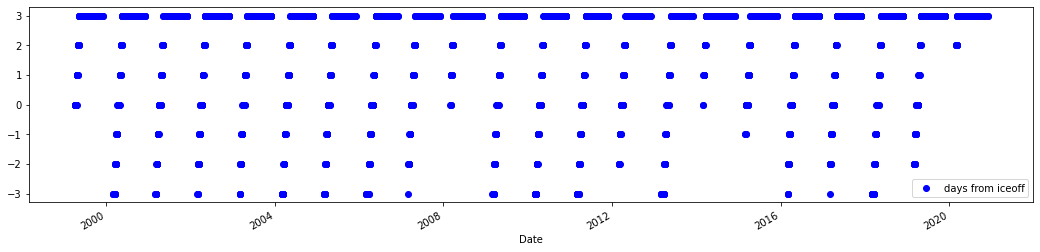

In [183]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
print(cd)
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short: ')
print('Input data of all the lakes can be found in Training data folder.')
filename = input('Input data file name (without .csv): ')
all_df = pd.read_csv(filename+'.csv',sep = '\t',parse_dates = ['Date'])

## Specify the training year
year = all_df['Date'].apply(lambda d:d.year).unique()
print('Dataset contains years:{},in total {} years'.format(year,len(year)))#[2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 
num_trainingyr = int(input('Number of years for training:'))
training_yr = []
for i in range(num_trainingyr):
    yr = int(input('Training year:'))
    training_yr.append(yr)

print(all_df.columns)
Ice_variable=input('Ice variables? (Y/N)')
if Ice_variable=='Y':
    ## Modifiy iceoff_day variable
    iceoff_name=input('name of iceoff variable:')

    modify=input('Modify iceoff_day? (Y/N)')
    if modify=='Y':
        all_df[iceoff_name]=all_df.apply(lambda x:modify_iceoff_day(x,iceoff_name), axis=1)

    ## categorize ice information
    all_df[['Date',iceoff_name]].plot(x='Date',y=iceoff_name,style='bo',figsize=(18,4))
    all_df[iceoff_name]=pd.Categorical(all_df[iceoff_name])

    ice_d_name=input('Name of ice duration variable:')
    modify=input('Modify ice duration? (Y/N)')
    if modify=='Y':
        all_df[ice_d_name]=all_df.apply(lambda x:modify_ice_d(x,ice_d_name), axis=1)

    ## categorize ice information
    all_df[ice_d_name]=pd.Categorical(all_df[ice_d_name])
else:
    iceoff_name = ''
    ice_d_name = ''

zoo_variable=input('Zooplankton variable? (Y/N)')
if zoo_variable=='Y':
    zoo_name=input('name of zooplankton: ')
    modify=input('Modify zooplankton level? (Y/N)')
    if modify=='Y':
        all_df[zoo_name]=all_df.apply(lambda x:modify_Daphnia(x,zoo_name), axis=1)
    ## categorize zooplankton
    all_df[zoo_name]=pd.Categorical(all_df[zoo_name])
else:
    zoo_name=''

## Get variables dommies
test_df=all_df.copy()

In [189]:
while True:
    binary_f=input('Name of binary feature: ')
    if binary_f=='':
        break
    test_df[binary_f]=pd.Categorical(test_df[binary_f])
Ice_c=input('Ice categorization? (Y/N)')
if Ice_c=='Y':
    test_df=pd.concat([test_df,pd.get_dummies(test_df[[iceoff_name,ice_d_name]])],axis=1).drop([iceoff_name,ice_d_name],axis=1)              
zoo_c=input('Zooplankton categorization? (Y/N)')
if zoo_c=='Y':
        test_df=pd.concat([test_df,pd.get_dummies(test_df[[zoo_name]])],axis=1).drop([zoo_name],axis=1)              

all_df=test_df.copy()
print(all_df.columns)
n_feature = int(input('Number of daily features used for training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)
Daily_features=features.copy()

Name of binary feature: 
Ice categorization? (Y/N)Y
Zooplankton categorization? (Y/N)N
Index(['Date', 'Bloom', 'NOX', 'DO_sur', 'DO_bot', 'PO4', 'TotP', 'NH4', 'Si',
       'Chl', 'SST', 'delT', 'U', 'AirT', 'Humidity', 'CC', 'Prec', 'SWR',
       'inflow', 'outflow', 'MM', 'thermD', 'MLD', 'W', 'accum_BotT', 'St',
       'days from iceoff_-3', 'days from iceoff_-2', 'days from iceoff_-1',
       'days from iceoff_0', 'days from iceoff_1', 'days from iceoff_2',
       'days from iceoff_3', 'Ice_d_long', 'Ice_d_middle', 'Ice_d_short'],
      dtype='object')
Number of daily features used for training: 24
Feature:U
Feature:AirT
Feature:delT
Feature:Humidity
Feature:CC
Feature:Prec
Feature:SWR
Feature:inflow
Feature:outflow
Feature:thermD
Feature:MLD
Feature:W
Feature:accum_BotT
Feature:St
Feature:days from iceoff_-3
Feature:days from iceoff_-2
Feature:days from iceoff_-1
Feature:days from iceoff_0
Feature:days from iceoff_1
Feature:days from iceoff_2
Feature:days from iceoff_3
Feature:Ice

In [190]:
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),
             pd.Timestamp(int(input('test ends in year:')),12,31)]

Nut_num = int(input('How many nutrients to predict? (put them in order) '))
Nut=[]
for i in range(Nut_num):
    Nut.append(input('Nut_'+str(i+1)+': '))
Nut_f = ['Date']+Nut

test starts in year:2017
test ends in year:2020
How many nutrients to predict? (put them in order) 2
Nut_1: DO_sur
Nut_2: DO_bot


Winter data or not? (Y/N)N
DO_sur
Number of samples: 684
Training dataset evaluation:
MAE 22.17 (+/- 7.59)
RMSE 29.55 (+/- 10.86)
R2 0.62 (+/- 0.10)


Important features: ['AirT' 'U' 'days from iceoff_3' 'Humidity' 'MLD' 'W' 'delT' 'inflow'
 'thermD' 'St' 'outflow' 'accum_BotT']


DO_bot
Number of samples: 674
Training dataset evaluation:
MAE 53.52 (+/- 5.90)
RMSE 72.21 (+/- 3.91)
R2 0.55 (+/- 0.20)


Important features: ['Humidity' 'thermD' 'U' 'delT' 'outflow' 'days from iceoff_-1' 'St'
 'accum_BotT' 'inflow' 'AirT' 'DO_sur' 'W']


Model takes 2 min to run


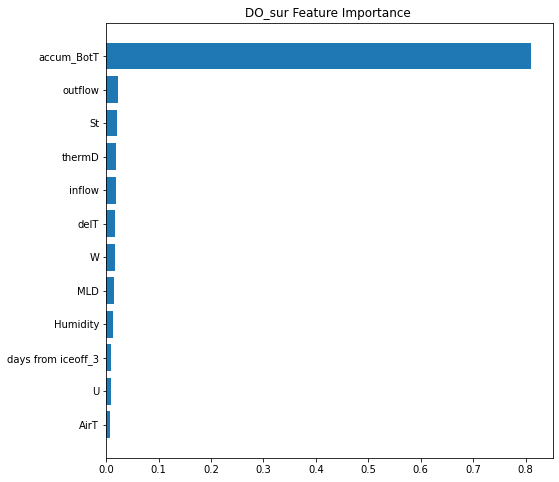

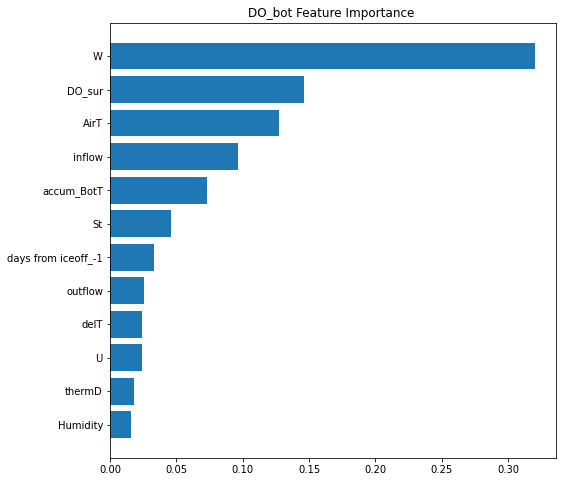

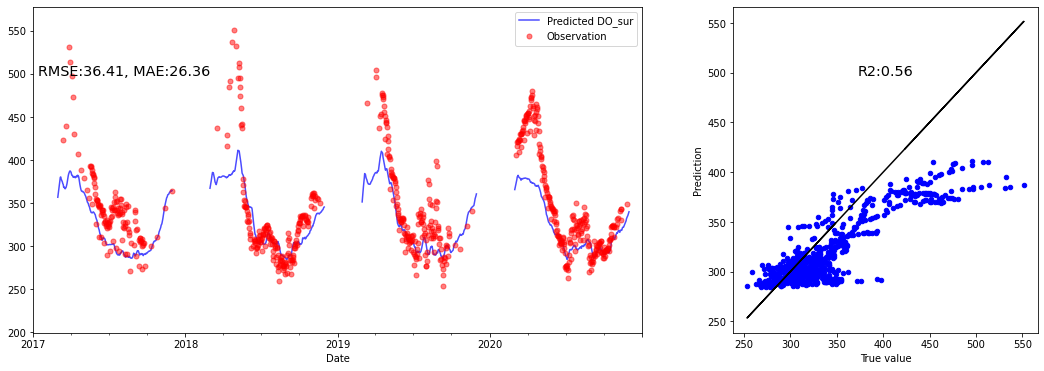

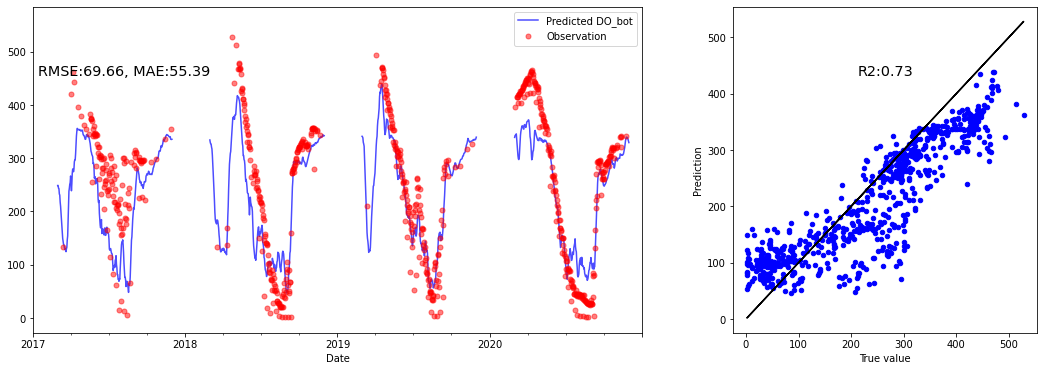

In [240]:
Lake_Nut_metrics = pd.DataFrame(columns = Nut,index=['MAE','RMSE','R2'])
Lake_Nut=pd.DataFrame(columns = ['Date'])

os.chdir(cd+'\\Trainning data')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'

testing_daily_df = read_daily_test_df(Daily_features,Ice_c,iceoff_name,ice_d_name,zoo_name,file).dropna()

os.chdir(cd+'\\Nutrient prediction\\'+lakename)
loss_func='huber'
features.pop(0)
Sorted_f=np.array([])
start_time = time.time()
for j in range(Nut_num): 
    if j!=0:
        features.append(Nut[j-1]) 
    nutrient=Nut[j]
    print(nutrient)    
    if j==0:
        model = training_cv(all_df,features,nutrient,training_yr,loss_func)
    else:
        model = training_cv(testing_daily_df.merge(all_df[['Date']+[nutrient]],on='Date',how='outer')
                            ,features,nutrient,training_yr,loss_func)
    ylim = (0,all_df[Nut[j]].max())
    Model,Lake_Nut_metrics = predict(testing_daily_df,all_df,
                                          features,nutrient,test_time,
                                          ylim,Lake_Nut_metrics)
    Lake_Nut =Lake_Nut.merge(Model,on=['Date'],how='outer')
    print('\n')
    
    # Feature importance for modelling nutrients
    GBR = pickle.load(open('GBR.'+Nut[j]+'.dat','rb'))
    feature_importance = GBR.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(round(n_feature/2)) + 0.5 #sorted_idx.shape[0]
    sorted_f=np.array(features)[sorted_idx]
    fig = plt.figure(figsize=(8, 8))
    plt.barh(pos, feature_importance[sorted_idx][-round(n_feature/2):], align="center")
    plt.yticks(pos, sorted_f[-round(n_feature/2):])
    plt.title(Nut[j]+" Feature Importance ")
    Sorted_f=np.concatenate((Sorted_f,sorted_f[-round(n_feature/2):]),axis=0)
    print('Important features: {}'.format(sorted_f[-round(n_feature/2):]))
    print('\n')
#features.append(Nut[-1])
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')

# 7-day window to smooth the prediction 
Lake_Nut_mean=pd.concat([Lake_Nut['Date'],Lake_Nut.rolling(7,min_periods = 1).mean()],axis=1)
Lake_Nut_mean.drop_duplicates('Date',inplace=True)

os.chdir(cd+'\\Nutrient prediction\\'+lakename+'\\step 1')

for k in range(Nut_num):
    nutrient_compare = Lake_Nut_mean[['Date',Nut[k]]].merge(all_df[['Date',Nut[k]]],
                                                          how = 'inner',on = 'Date').dropna()
    nutrient_compare.columns = ['Date','Prediction','True']
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']<test_time[1])&(nutrient_compare['Date']>test_time[0])]
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Lake_Nut_mean,how = 'left',on = 'Date')
 
    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared=False)
    MAE = mean_absolute_error(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot time-series comparison
    f1,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =Nut[k],c = 'b',ax = ax2[0],alpha=0.7,label = 'Predicted '+Nut[k])
    #Lake_Nut_gap[Nut[k]] = Lake_Nut_gap[Nut[k]].rolling(7,min_periods = 1).mean()
    #Lake_Nut_gap.plot(x = 'Date',y =Nut[k],c = 'k',ax = ax2[0],alpha=0.7,
    #                  label = 'Predicted 7d-averaged '+Nut[k])
    all_df[['Date',Nut[k]]].plot(x = 'Date',y =Nut[k],style = 'ro',ms = 5,alpha = 0.5,ax = ax2[0],
                       label = 'Observation')

    ax2[0].text(0.15, 0.8, 'RMSE:{}, MAE:{}'.format(round(RMSE,2),round(MAE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')

    ax2[0].set_xlim((test_time[0],test_time[1]))
    #ax2[0].set_ylim(Lake_Nut[Nut[k]].min(),Lake_Nut[Nut[k]].max())

    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    f1.savefig(lakename+'_GBR_'+Nut[k]+'.png',dpi = 500)    
Lake_Nut_mean.to_csv(lakename+'_GBR_nutrient prediction.csv',sep='\t',index=False)
Sorted_f=Sorted_f.reshape(len(Nut),round(n_feature/2))
for i in range(Nut_num):
    nutrient_compare=Lake_Nut_mean[['Date',Nut_f[i+1]]].merge(all_df[['Date',Nut_f[i+1]]],on='Date',how='inner').dropna()
    nutrient_compare.columns=['Date','Pred','True']
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']>test_time[0])&(nutrient_compare['Date']<test_time[1])]
    Lake_Nut_metrics[Nut_f[i+1]]['MAE']=round(mean_absolute_error(nutrient_compare['True'],nutrient_compare['Pred']),2)
    Lake_Nut_metrics[Nut_f[i+1]]['RMSE']=round(mean_squared_error(nutrient_compare['True'],nutrient_compare['Pred'],
                                                                  squared=False),2)
    Lake_Nut_metrics[Nut_f[i+1]]['R2']=round(r2_score(nutrient_compare['True'],nutrient_compare['Pred']),2)
Lake_Nut_metrics.to_csv('Lake nutrient metrics.csv',index=True)

In [242]:
Lake_Nut_metrics

,DO_sur,DO_bot
MAE,26.36,55.39
RMSE,36.41,69.66
R2,0.56,0.73


# Step 2: Use LSTM to update the prediction

DO_sur
(4899, 8, 12) (4899,) (1093, 8, 12) (1093,)
number of input timesteps: 8
number of features: 12
number of samples: 684
Training dataset RMSE 25.80 (+/- 3.71)
Training dataset MAE 17.26 (+/- 2.70)
Training dataset R2 0.77 (+/- 0.08)
Test RMSE: 28.57
Test MAE: 22.42
Test R2: 0.73
Model takes 7 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


DO_bot
(4899, 8, 12) (4899,) (1093, 8, 12) (1093,)
number of input timesteps: 8
number of features: 12
number of samples: 674
Training dataset RMSE 62.34 (+/- 5.80)
Training dataset MAE 44.58 (+/- 4.20)
Training dataset R2 0.71 (+/- 0.06)
Test RMSE: 57.29
Test MAE: 42.98
Test R2: 0.82
Model takes 15 min to run




c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Model takes 15 min to run


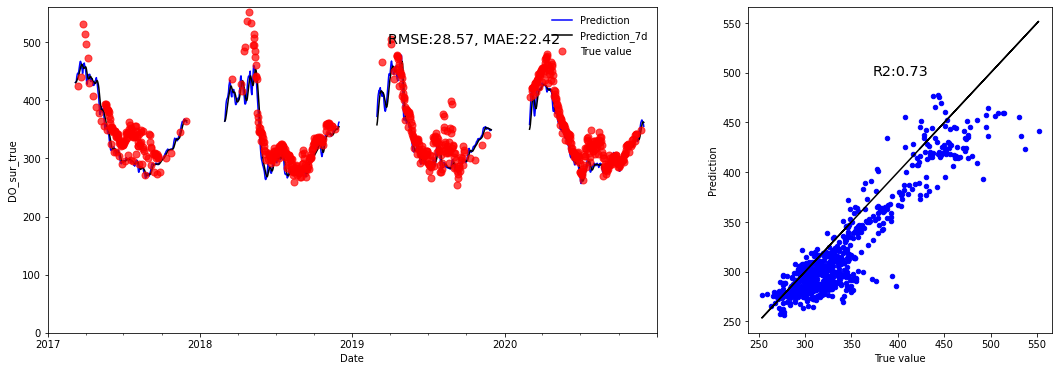

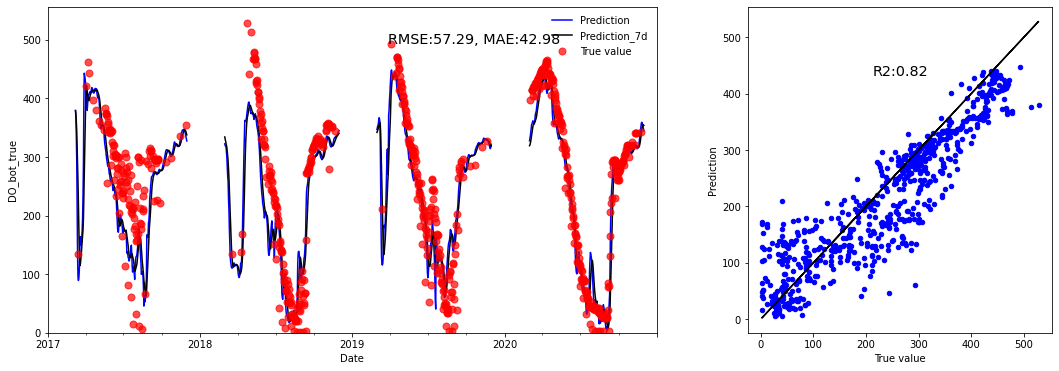

In [255]:
Lake_Nut_metrics = pd.DataFrame(columns = Nut_f[1:],index=['MAE','RMSE','R2'])
Lake_Nut=pd.DataFrame(columns = ['Date'])
Nut_df=all_df[Nut_f]
Nut_df.columns=['Date']+[s+'_true' for s in Nut_f[1:]]

# set the hyperparameters
hyperparameters = {'n_batch':30,'nb_epoch':100,'n_neuros':100,'dropout':0.2,'time_steps':7,
                   'n_out':1,'verbose':0,'loss_function':'mae'}

## Dataset_range
Dataset_range = [pd.Timestamp(year[0],1,1),
             pd.Timestamp(year[-1],12,31)]
start_time = time.time()
os.chdir(cd+'\\Trainning data')
# Load daily physical factors
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'

# Merge the observed daily environmental factors with pre-generated DO and nutrient from last step
Daily_df = read_daily_test_df(Daily_features,Ice_c,iceoff_name,ice_d_name,zoo_name,file).merge(Lake_Nut_mean,on='Date',how='inner')
Daily_df = Daily_df[(Daily_df['Date']>=Dataset_range[0])&(Daily_df['Date']<=Dataset_range[1])]

Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)
start_time = time.time()
for j in range(Nut_num):
    nutrient=Nut_f[j+1]
    if j==0:
        Nut_memory = Daily_df.merge(pd.concat([Nut_df['Date'],
                                               Nut_df[nutrient+'_true']],
                                              axis = 1).dropna().drop_duplicates('Date'),
                                    how = 'left',on = 'Date')
    else: 
        Nut_memory = Nut_memory.merge(pd.concat([Nut_df['Date'],
                                               Nut_df[nutrient+'_true']],
                                              axis = 1).dropna().drop_duplicates('Date'),
                                    how = 'left',on = 'Date')

    print(nutrient)
    ft=list(Sorted_f[j])
    ft.append(nutrient+'_true')
    values = load_dataset(Nut_memory,ft)
    # frame as supervised learning
    reframed = reframe(values,hyperparameters,ft)
    reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),
                                 columns=reframed.columns[:-1])
    target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
                 name=reframed.columns[-1])

    #target_scaled=pd.Series(Scaler_y.fit_transform(reframed.iloc[:,-1].values.reshape(-1, 1)).reshape(-1),
    #                 name=reframed.columns[-1])
    reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
    values = reframed_scaled.values
    ylim = (0,all_df[nutrient].max())
    Nut_model,rmse,mae,r2,figure,pred_ts = predict_lstm(Nut_memory,values,ft,nutrient+'_true',test_time,hyperparameters,ylim)
    # 5-fold cross validation was used to estimate the model performance
    print('Test RMSE: %.2f' % rmse)
    print('Test MAE: %.2f' % mae)
    print('Test R2: %.2f' %r2)
    Lake_Nut_metrics[nutrient]['MAE']=mae
    Lake_Nut_metrics[nutrient]['RMSE']=rmse
    Lake_Nut_metrics[nutrient]['R2']=r2
    print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
    os.chdir(cd+'\\Nutrient prediction\\'+lakename+'\\step 2')
    figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)    
    print('\n')
    Nut_memory = predict_ts(Nut_memory,nutrient+'_true',Nut_model,hyperparameters,values)
    Nut_memory[nutrient]=Nut_memory[nutrient+'_true']
    ft.pop()
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
Lake_Nut_metrics.to_csv('Lake nutrient metrics.csv',index=True)

In [256]:
Lake_Nut_metrics.astype('float64').round(decimals=2)

,DO_sur,DO_bot
MAE,22.42,42.98
RMSE,28.57,57.29
R2,0.73,0.82


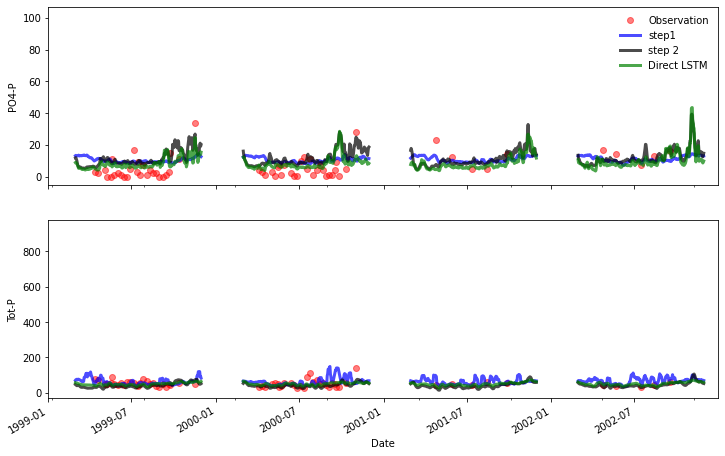

In [68]:
os.chdir(cd+'\\Nutrient prediction\\'+lakename+'\\direct LSTM')
Direct_LSTM=pd.read_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep='\t',parse_dates=['Date'])

f,ax=plt.subplots(nrows=Nut_num,sharex=True,figsize=(12,4*Nut_num))
Date = pd.DataFrame(pd.date_range(start = Nut_memory['Date'].iloc[0],
                              end = Nut_memory['Date'].iloc[-1]),
                columns = ['Date'])
Nut_memory_nogap=Date.merge(Nut_memory,on='Date',how='left')
Direct_LSTM_nogap=Date.merge(Direct_LSTM,on='Date',how='left')

for i in range(Nut_num):
    nutrient_compare=Nut_memory[['Date',Nut_f[i+1]]].merge(all_df[['Date',Nut_f[i+1]]],on='Date',how='inner').dropna()
    nutrient_compare.columns=['Date','Pred','True']
    nutrient_compare=nutrient_compare[(nutrient_compare['Date']>test_time[0])&(nutrient_compare['Date']<test_time[1])]
    Lake_Nut_metrics[Nut_f[i+1]]['MAE']=round(mean_absolute_error(nutrient_compare['True'],nutrient_compare['Pred']),2)
    Lake_Nut_metrics[Nut_f[i+1]]['RMSE']=round(mean_squared_error(nutrient_compare['True'],nutrient_compare['Pred'],
                                                                  squared=False),2)
    Lake_Nut_metrics[Nut_f[i+1]]['R2']=round(r2_score(nutrient_compare['True'],nutrient_compare['Pred']),2)
    all_df.plot(x='Date',y=Nut_f[i+1],ax=ax[i],style ='ro',alpha=0.5,label='Observation')
    Date.merge(Lake_Nut_mean,on='Date',how='left').plot(x='Date',y=Nut_f[i+1],ax=ax[i],
                    style ='b-',lw=3,alpha=0.7,label='step1')
    Nut_memory_nogap.plot(x='Date',y=Nut_f[i+1],ax=ax[i],
                style ='k-',lw=3,alpha=0.7,label='step 2')
    
    Direct_LSTM_nogap.plot(x='Date',y=Nut_f[i+1],ax=ax[i],
                style ='g-',lw=3,alpha=0.7,label='Direct LSTM')
    if i==0:
        ax[i].legend(frameon=False)
    else:
        ax[i].legend('',frameon=False)
    ax[i].set_xlim([test_time[0],test_time[1]])
    ax[i].set_ylabel(Nut_f[i+1])
os.chdir(cd+'\\Nutrient prediction\\'+lakename)
f.savefig('Nutrient comparison.png',dpi=300)

In [69]:
os.chdir('..\\step 2')

In [71]:
Lake_Nut_metrics=pd.read_csv('Lake nutrient metrics.csv',index_col=0)
Lake_Nut_metrics.round(decimals=2)

,O2,PO4
MAE,34.95,0.96
RMSE,45.52,1.20
R2,0.57,-2.38
